# Disaster Tweet Data

This dataset contains tweets categorized as relating to various disasters like floods, earthquakes, wildfires. Each tweet entry likely has details like the text content, user information, metrics like retweets and comments, and relevant hashtags.

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding,Masking,LSTM, GRU, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN
from tensorflow.keras.datasets import reuters
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import tensorflow_hub as hub

# Import Data and Basic EDA

In [2]:
data = pd.read_csv("/kaggle/input/disaster-tweets/tweets.csv", index_col = 'id' )
# shuffle the dataset 
data_shuffled = data.sample(frac=1, random_state=1)
data_shuffled.head(10)

,keyword,location,text,target
id,,,,
11132,windstorm,"Ridgway, PA",2 seconds. Why is she singing through her nose...,0
2116,catastrophe,NaN,"Water being trucked in , watching 7, 30 this i...",0
5593,fire,"Nashville, TN",i want some fire ass head.😭,0
4139,disaster,Sydney,Joined Premier &amp; Comm Baxter today to visi...,0
6133,hailstorm,"Chennai, India","UAE bracing up for heavy rain, hailstorm in UA...",1
3289,debris,NaN,"Unfortunately, both plans fail as the 3 are im...",0
8676,riot,NaN,if that thread is true and justin was a victim...,0
8136,panicking,Pearl Of The Orient,That's your positive side kicking in. But to d...,0
8213,police,NaN,"In 12 Northern States, the Hisbah (Islamic Pol...",0


In [3]:
data.shape

(11370, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11370 entries, 0 to 11369
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   11370 non-null  object
 1   location  7952 non-null   object
 2   text      11370 non-null  object
 3   target    11370 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 444.1+ KB


In [5]:
data.describe(include = object).T

,count,unique,top,freq
keyword,11370,219,thunderstorm,93
location,7952,4504,United States,96
text,11370,11223,We wanted to entertain you all with a good mov...,3


# Train Test Split

In [6]:
# split the data into 90% training and 10% testing
X_train, X_test, y_train, y_test = train_test_split(data_shuffled["text"].to_numpy(),
                                                    data_shuffled["target"].to_numpy(),
                                                    test_size = 0.1,
                                                    random_state=1)
X_train.shape, y_train.shape

((10233,), (10233,))

In [7]:
X_train[0:5]

array(['The picture is from 2001, after fall of Taliban. They destroyed it by bombing during their regime in Afg b… https://t.co/hnnq4OGscG',
       'Presenting Asim Riaz Bravo :P "Hello 911 it\'s an emergency, there is a handsome guy in my house, oh! Wait a second cancel t…',
       '"Once the [scrapping] sale contract has been signed and the deal done, you have to ask how much else is expected of a dil…',
       'No Greta Gerwig for ‘Little Women,’ no Lulu Wang for ‘The Farewell,’ no Lorene Scafaria for ‘Hustlers,’ no Melina Matsou…',
       'It’s funny because I’ve lived in tundra szn and I’ve walked home from work in a snowstorm on a day… https://t.co/O1LHRHTY3w'],
      dtype=object)

In [11]:
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1,_ = precision_recall_fscore_support(y_true, y_pred,average="weighted")
    model_results = {"accuracy":model_accuracy,
                     "precision":model_precision,
                     "recall" :model_recall,
                     "f1":model_f1}
    return model_results

# Import Transfer Learning Model
## Universal Sentence Encoder

In [14]:
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                               input_shape=[],
                               dtype = tf.string,
                               trainable=False)

Attaching model 'google/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2' to your Kaggle notebook...


In [ ]:
#pip install tensorflow

# Model

In [15]:
model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.compile(loss="binary_crossentropy",
                     optimizer="adam",
                     metrics=["accuracy"])

Epoch 1/20


I0000 00:00:1715105340.255776     191 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 11s 13ms/step - loss: 0.4327 - accuracy: 0.8327 - val_loss: 0.3331 - val_accuracy: 0.8672
Epoch 2/20
320/320 [==============================] - 3s 10ms/step - loss: 0.3023 - accuracy: 0.8780 - val_loss: 0.2985 - val_accuracy: 0.8795
Epoch 3/20
320/320 [==============================] - 3s 10ms/step - loss: 0.2808 - accuracy: 0.8860 - val_loss: 0.2873 - val_accuracy: 0.8901
Epoch 4/20
320/320 [==============================] - 3s 10ms/step - loss: 0.2713 - accuracy: 0.8902 - val_loss: 0.2818 - val_accuracy: 0.8883
Epoch 5/20
320/320 [==============================] - 3s 10ms/step - loss: 0.2654 - accuracy: 0.8932 - val_loss: 0.2787 - val_accuracy: 0.8883
Epoch 6/20
320/320 [==============================] - 3s 10ms/step - loss: 0.2612 - accuracy: 0.8954 - val_loss: 0.2763 - val_accuracy: 0.8901
Epoch 7/20
320/320 [==============================] - 3s 10ms/step - loss: 0.2571 - accuracy: 0.8963 - val_loss: 0.2755 - val_accuracy: 0.8927
Epoch 8/2

<Axes: >

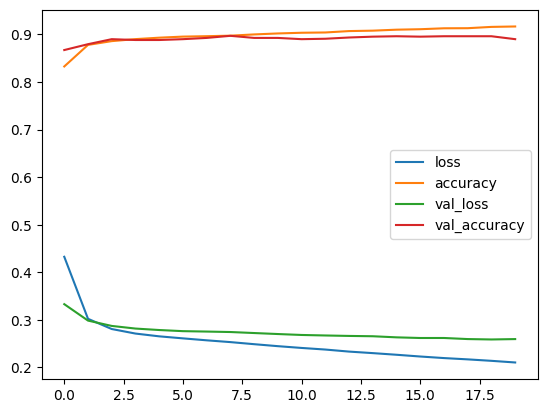

In [16]:
model_history = model.fit(x=X_train,
              y=y_train,
              epochs=20,
              validation_data=(X_test,y_test))
pd.DataFrame(model_history.history).plot()

# Model Evaluation

In [18]:
calculate_results(y_true=y_test,
                  y_pred=tf.squeeze(tf.round(model.predict(X_test))))

36/36 [==============================] - 0s 9ms/step


{'accuracy': 0.890061565523307,
 'precision': 0.8880208815427183,
 'recall': 0.890061565523307,
 'f1': 0.8889224064466924}